<p style="text-align: center;">  MDS & CLUSTERING OF GLOBAL SOCIOECONOMIC INDICATORS </p>

<p style="text-align: center;"> Daniel Losada </p>
<p style="text-align: center;"> Gabriel Pons </p>
<p style="text-align: center;"> Raúl Rodríguez </p>

<p style="text-align: center;"> November 2024 </p>
<p style="text-align: center;"> Multivariate Analysis </p>

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.manifold import MDS
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform


#https://pypi.org/project/PyDistances/
#https://fabioscielzoortiz.github.io/PyDistances-book/intro.html
from PyDistances.mixed import GGowerDistMatrix
from PyDistances.mixed import RelMSDistMatrix
from sklearn.preprocessing import StandardScaler

# to use PyDistances.mixed we also require:
import polars
import scipy

from pyclustering.cluster.kmedoids import kmedoids
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

from scipy.spatial.distance import mahalanobis
from scipy.linalg import inv
import matplotlib.image as mpimg


# 1. Input Data

First of all the dataset is included again.

To see how it works the information about it is added.

Our study is based on a huge dataset with data collected from almost all countries in the world. Some variables are not in this dataset from Kaggle, so we have implemented them to complete the compulsory rules about this project.
The idea is to analyze some socio-economic variables that allow us to have an overview about relations between these variables and its behaviour in each country (observation). To do so we have chosen from Kaggle the following variables: 

-	`child_mort`: death of children under 5 years per 1000 live births (continuous)

-	`exports`: Exports of goods and services per capita as % of the GDP per capita (continuous)

-	`health`: Health spending per capita as % of GDP per capita (continuous)

-	`imports`: Imports of goods and services as % of the GDP per capita (continuous)

-	`income`: Net income per person (continuous)

-	`inflation`: Inflation as a measurement of the annual growth rate of the total GDP (continuous)

-	`life_expec`: Average number of years a newborn child would live if the current mortality patterns are to remain the same (continuous)

-	`total_fer`: number of children that would be born to each woman if the current age-fertility rates remain the same (continuous)

-	`gdpp`: GDP per capita (continuous)

Then we added new variables:

-	`idh`: Human development index, calculated from some measures of welfare, and belonging to the $(0,1)$ interval, being 1 the best conditions to live and 0 the worst. (continuous but adapted to be binary)

- `regime_type`: showing how their model of government is (categorical) accompained of a continuous variable (index_2023) that clasify numerically the regime type, but we are not going to take it into account.

-	`continent`: What continent does each country belong to (categorical)

-	`coast`: if it has a coast or not (binary)

The data of `idh` is taken from [Wikipedia](https://en.wikipedia.org/wiki/List_of_countries_by_Human_Development_Index#List). The index is published every year by the UNDP.

The data of `regime_type` is taken from [Wikipedia](https://en.wikipedia.org/wiki/The_Economist_Democracy_Index#List_by_country). From a list made by The Economist. We took the last data available, from 2023.

The data of `continent` and `coast` was generated by Chat GPT and then corrected by us.

Binary, multiclass and quantitative data are defined to ensure its behaviour in the dataset

In [2]:
df = pd.read_csv('Countries.csv')
df.head()

country  child_mort  exports  health  imports  income  inflation  \
0  Afghanistan        90.2     10.0    7.58     44.9    1610       9.44   
1      Albania        16.6     28.0    6.55     48.6    9930       4.49   
2      Algeria        27.3     38.4    4.17     31.4   12900      16.10   
3       Angola       119.0     62.3    2.85     42.9    5900      22.40   
4    Argentina        14.5     18.9    8.10     16.0   18700      20.90   

   life_expec  total_fer   gdpp       regime_type      continent  coast  \
0        56.2       5.82    553     Authoritarian           Asia  False   
1        76.3       1.65   4090  Flawed democracy         Europe   True   
2        76.5       2.89   4460     Authoritarian         Africa   True   
3        60.1       6.16   3530     Hybrid regime         Africa   True   
4        75.8       2.37  10300  Flawed democracy  South America   True   

   binary_idh  
0       False  
1        True  
2        True  
3       False  
4        True

In [3]:
binary_columns = ['binary_idh', 'coast']
multiclass_columns = ['continent', 'regime_type']
quantitative_columns = ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

# 2. Distances

 To obtain general statistical information about the quantitative variables the mean and standard deviation is performed. It will be used to compare the values of each observation and the main parameters of the variable. 


After that, we are going to apply distances in order to perform the analysis in these terms. The analysis allow us to represent observations in a metric space interpreting in a gemotric way.

We are going to see the different distances and which of them are going to be applied to the different class of data or the situation that is going to be analyzed.

In [4]:
df_trans = df.copy()

scaler = StandardScaler()

# Apply standardization to all columns in the dataframe and replace them
#df_trans[quantitative_columns] = scaler.fit_transform(df_trans[quantitative_columns])
#display(df_trans.head())
df_trans.describe().loc[['mean', 'std']]

child_mort    exports    health    imports        income  inflation  \
mean   39.896711  40.942099  6.824934  45.433986  17402.519737   8.267224   
std    41.718840  27.827826  2.734831  24.205912  19298.298758  10.874995   

      life_expec  total_fer          gdpp  
mean   70.530263   2.960461  13303.052632  
std     9.161379   1.560300  18941.334205

In order to work better with distances, specially with Mahalanobis, the categorical variables are transformed into dummy variables. It allows us to control better every category of the variables and take into account the variance and covariance between variables (as perform the covariance matrix). Also the variables are numericalized. In other case, the distances cannot be performed and the weight of each category won't have wel behaviour. 

For example, creating new binary variables for each continent, the distances and differences between variables and cateogries allows to work in this topic:

$X_{11}: continent$ is divided into 5 new variables:

$$Y_1: continent\_ Asia $$
$$Y_2: continent\_ Europe $$
$$Y_3: continent\_ North America$$ 
$$Y_4: continent\_ Oceania$$
$$Y_5: continent\_ South America$$
$$Y_i=  \left\{\begin{matrix}
1 & if & yes \\
0 & if & no \\
\end{matrix}\right.$$

And in the same way are performed `regime_type` creating 3 new binary variables.

In [5]:

for col in binary_columns:
    df_trans[col] = df_trans[col].astype(int)  # Binary: True/False -> 1/0

df_trans = pd.get_dummies(df_trans, columns=multiclass_columns, drop_first=True, dtype=int)  # One-Hot Encoding
df_trans.head()

country  child_mort  exports  health  imports  income  inflation  \
0  Afghanistan        90.2     10.0    7.58     44.9    1610       9.44   
1      Albania        16.6     28.0    6.55     48.6    9930       4.49   
2      Algeria        27.3     38.4    4.17     31.4   12900      16.10   
3       Angola       119.0     62.3    2.85     42.9    5900      22.40   
4    Argentina        14.5     18.9    8.10     16.0   18700      20.90   

   life_expec  total_fer   gdpp  coast  binary_idh  continent_Asia  \
0        56.2       5.82    553      0           0               1   
1        76.3       1.65   4090      1           1               0   
2        76.5       2.89   4460      1           1               0   
3        60.1       6.16   3530      1           0               0   
4        75.8       2.37  10300      1           1               0   

   continent_Europe  continent_North America  continent_Oceania  \
0                 0                        0                  0   
1                 1                        0                  0   
2                 0                        0                  0   
3                 0                        0                  0   
4                 0                        0                  0   

   continent_South America  regime_type_Flawed democracy  \
0                        0                             0   
1                        0                             1   
2                        0                             0   
3                        0                             0   
4                        1                             1   

   regime_type_Full democracy  regime_type_Hybrid regime  
0                           0                          0  
1                           0                          0  
2                           0                          0  
3                           0                          1  
4                           0                          0

In [6]:
new_multiclass_columns = list(set(df_trans.columns) - set(quantitative_columns) - set(binary_columns) - {'country'})
new_multiclass_columns

['regime_type_Full democracy',
 'regime_type_Flawed democracy',
 'continent_Oceania',
 'continent_North America',
 'continent_Europe',
 'regime_type_Hybrid regime',
 'continent_Asia',
 'continent_South America']

In order to perform the following analysis, the correlation matrix of quantitative variables is recovered. Also its inverse is calcualted. The calculus is directly performed by the functions of the package, but it is calculated to have it in hand.

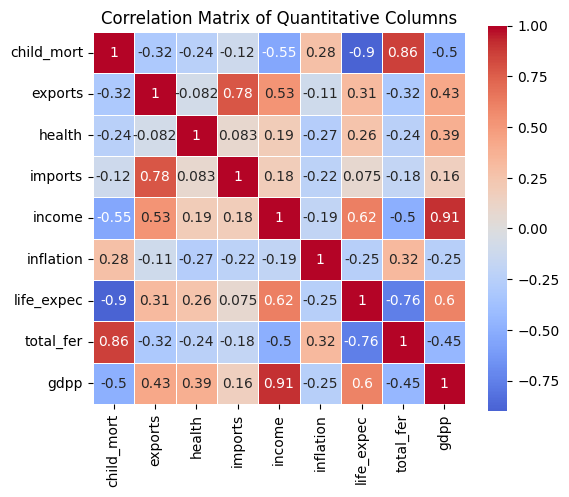

In [7]:
# Calculate the correlation matrix for the quantitative columns
correlation_matrix = df[quantitative_columns].corr()

plt.figure(figsize=(6, 5))

# Draw the heatmap with the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, square=True, linewidths=.5)

plt.title("Correlation Matrix of Quantitative Columns")
plt.show()

# Calculate the inverse
inv_cov=inv(correlation_matrix)

Let's explain briefly some theory about distances.

To measure distances between **quantitative** data:
1.  $l^q$ family of distances are taken into account (Euclidean distancs)
* The eculidean distance is the most basic one: its use is not recommendable because it assumes that data is uncorrelated (and as we can see in the correlations matrix that's not happening) and that is not scale invariant. Its calculation is as follows:
$$\delta_E^2(i,j)=\sum_{k=1}^p(x_{ik}-x_{jk})^2=(x_i-x_j)'(x_i-x_j)$$
Is the one used by default, but its use will situate two observations very near in terms of geometry, making an error since the observations are far away between them.
* Minkowski distance: performing it we have the same problem as before (notice that if $q=2$ the Euclidean distance is a particular case of Minkowski) and sometimes the Eculidean property is not fulfilled.
$$\delta_q(i,j)=\left(\sum_{k=1}^p|x_{ik}-x_{jk}|^q\right)^{1/q}$$

As special cases we have:
* Manhattan distance $l^1$
$$\delta_1(i,j)=\sum_{k=1}^p|x_{ik}-x_{jk}|$$

* Dominant distance $ l^{\infty} $:
  
$$\delta_\infty(i,j)=max\{|x_{i1}-x_{j1}|,...,|x_{ip}-x_{jp}|\}$$

2. Scale invariant distances
* Canberra distance:
$$\delta_C(i,j)=\sum_{k=1}^p\frac{|x_{ik}-x_{jk}|}{|x_{ik}|-|x_{jk}|}$$
* Karl Pearson's distance (as standardized Euclidean distance to unit variance but assuming uncorrelated variables):
$$\delta_K(i,j)=\sum{k=1}^p\frac{(x_{ik}-x_{jk})^2}{s_k^2}=(x_{i}-x_{j})'S_0^{-1}(x_{i}-x_{j})$$
* **Mahalanobis distance**: This is the one that we are going to use. It is scale invariant (as we will se after). Also we ensure that the distance between varaibles doesn't increase when adding a new (correlated) variable, because the correlation matrix is taking into account. If an uncorrelated variable is added, the distances will increase between observations.

$$\delta_M^2(i,j)=(x_{i}-x_{j})'S^{-1}(x_{i}-x_{j})$$

Here $\textbf{S}$ is the sample covariance matrix.

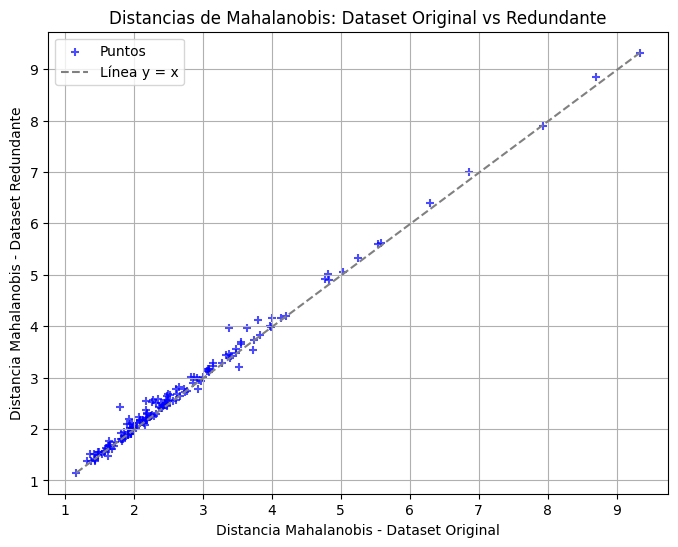

child_mort  exports  health  imports  income  inflation  life_expec  \
0        90.2     10.0    7.58     44.9    1610       9.44        56.2   
1        16.6     28.0    6.55     48.6    9930       4.49        76.3   
2        27.3     38.4    4.17     31.4   12900      16.10        76.5   
3       119.0     62.3    2.85     42.9    5900      22.40        60.1   
4        14.5     18.9    8.10     16.0   18700      20.90        75.8   

   total_fer   gdpp  Mahalanobis_Distance  
0       5.82    553              2.915424  
1       1.65   4090              1.834591  
2       2.89   4460              1.835246  
3       6.16   3530              3.335445  
4       2.37  10300              2.113361

In [8]:
df_num=df[quantitative_columns].copy()

# Perform the covariance matrix  
cov_matrix = np.cov(df_num, rowvar=False)
inv_cov_matrix = inv(cov_matrix)

# Calculate the mean vector 
mean_vector = df_num.mean().values

# Calculate the Mahalanobis distances
distances = df_num.apply(lambda row: mahalanobis(row.values, mean_vector, inv_cov_matrix), axis=1)

# Create a dataset for redundancy of a variable
df_redundant = df_num.copy()
df_redundant["child_mort_new"] =df_num["child_mort"] * 100 + 6  # child_mort_new is a linear combination of child_mort

# Add the distances to the dataframe 
df_num['Mahalanobis_Distance'] = distances

# Calculate the mean vector with the new data frame and the inverse of the covariance matrix of the dataset with the redundant variable
mean_vector_redundant = df_redundant.mean().values
cov_matrix_redundant = np.cov(df_redundant, rowvar=False)
inv_cov_matrix_redundant = inv(cov_matrix_redundant)

# Calculate the Mahalanobis distance from the redundant dataset 
distances_redundant = df_redundant.apply(
    lambda row: mahalanobis(row.values, mean_vector_redundant, inv_cov_matrix_redundant), axis=1
)

# Plot distances and compare them
plt.figure(figsize=(8, 6))
plt.scatter(distances, distances_redundant, c='blue', marker='+', alpha=0.7, label="Puntos")
plt.plot([min(distances), max(distances)], 
         [min(distances_redundant), max(distances_redundant)], 
         color='gray', linestyle='--', label="Línea y = x")
plt.title("Distancias de Mahalanobis: Dataset Original vs Redundante")
plt.xlabel("Distancia Mahalanobis - Dataset Original")
plt.ylabel("Distancia Mahalanobis - Dataset Redundante")
plt.legend()
plt.grid()
plt.show()

df_num.head()

The head of data in quantitative variables is shown and the Mahalanobis distance is performed as new column in order to compare the original and the other.

As can be seen in the graph, the new varaible, even being completely correlated doesn't change the distances between observations, as we said before.

Before performing all distances between all type of variables, let's explain how to compute distances between non-quantitative variables.

Distances in **qualitative data**.

In this case sometimes is better to work with similarities, that show the proximity between observations in case of categorical variables. The similarities are defined as:

If in a set of units $\epsilon$, there exist an application $s:\epsilon \times \epsilon \rightarrow \mathbb{R}$ it is a similarity if:
$$ \forall \space i,j \space 0\leq s_{ij}\leq s_{ii}=1$$
$$ \forall \space i,j \space  s_{ij} = s_{ji}$$

In order to convert it to distance is useful the transformation $\delta_{ij}=\sqrt{1-s_{ij}}$ because the Euclidean property is applied.

In case of a value of $s_{ij}$ different from the range $[0,1]$ or if $s_{ii}\neq 1$ other transformation is used ($\delta_{ij}^2=s_{ii}+s_{jj}-2s_{ij}$).

Supossing that the qualitative dataset is formed by binary variables (as our case) the similarity coefficientes are performed by means of the following pairwise ($s_{ij}$)coefficients:

- $a$: frequency of variables with response 1 in both units
- $b$: frequency of variables with response 0 in unit $i$ and 1 in $j$
- $c$: frequency of variables with response 1 in unit $i$ and 0 in $j$
- $d$: frequency of variables with response 0 in both units
- $p$ = $a+b+c+d$

Lots of them can be performed, some of them fulfilling the euclidean property and others no, and taking different range of values.

In our case, we are going to use Sokal-Michener or Jackard similarity coefficient. Both fulfill the Euclidean property and can take values in $(0,1)$:
$$s_{ij}^{Sokal}=\frac{a+d}{p}$$
$$s_{ij}^{Jaccard}=\frac{a}{a+b+c}$$

In the dataset we have mixed type data so the Gower's distance can be performed. In other case it will be explained, but finally we decided to apply RelMS because its behaviour with outliers is better and more stable, and also doesn't give as importance as Gower to categorical variables.

In [9]:
ggower_dist_matrix = GGowerDistMatrix(p1=len(quantitative_columns), p2=len(binary_columns), p3=len(new_multiclass_columns), d1='robust_mahalanobis', d2='sokal', d3='hamming')
D = ggower_dist_matrix.compute(X=df_trans[quantitative_columns + binary_columns + new_multiclass_columns])

# 3. MDS

The use of RelMS allows us to plot distances in MDS maps as Euclidean distances or clustering.

A function in 'PyDistances' is performed. Inside the RelMS matrix, for quantitative variables, robust Mahalanobis is used, for binary data Jaccard and for categorical, Hamming.

The biggest disadvantage is the com`putational cost, but with only 152 observations (countries) it is not a problem. The positive things are more than negative ones: it allows to "combine any kind of data, whenever a distance measure can be computed between units".

Different steps are performed in RelMS (in this case dome with the package). Summing up:
- Check commensurateness of matrices $\textbf{D}_k^{(2)}$ imposing equal geometric variability.
- For each $\textbf{D}_k^{(2)}$ consider the Gram matrix $\textbf{G}_k=-\frac{1}{2}\textbf{H}\textbf{D}_k\textbf{H}$ where $\textbf{H}$ is the centering matrix.
- Obtain the joint metric through the Gram matrix:
$$\textbf{G}=\sum_{k=1}^m \textbf{G}_k-\frac{1}{m}\sum_{k\neq l}\textbf{G}_k^{1/2}\textbf{G}_l^{1/2}$$
- The distance matrix of the joint metric is:
$$\textbf{D}^{(2)}=g'1'+1g-2\textbf{G}$$
Where $g=diag(\textbf{G})$

## 3.1 RelMS

In [10]:
relms_dist_matrix = RelMSDistMatrix(len(quantitative_columns),len(binary_columns),len(new_multiclass_columns),
                                    d1="robust_mahalanobis", d2="jaccard", d3="hamming", 
                                    robust_method="trimmed", alpha=0.07, epsilon=0.05, 
                                    n_iters=20, weights=None)

D = relms_dist_matrix.compute(X=df_trans[quantitative_columns + binary_columns + new_multiclass_columns])

The goal of MDS is to represent the 152 countries as a matrix of pairwise distances in Euclidean space with principal coordinates, that are the ones that explain the biggest percentage of variability, in order to interpret the results in the best possible way. The main idea is to obtain 2 or 3 principal coordinates in order to work better.

Finding the best model to represent distances (in our case RelMS) the advantages of MDS are that distances between any type of data can be computed. Since our dataset is small, the only disadvantage that we can see is the difficult interpretation (sometimes) of these principal coordinates.

It is important to fulfill the Euclidean property. In other case, the data must be forced due to the necessity of working with distances fulfilling the Euclidean property. To solve this, in case of $\textbf{G} having negative eigenvalues, the following transformation is performed:

$$\tilde{\delta}_{ij}^2=\left\{\begin{matrix}
\delta_{ij}^2+c & i \neq j \\
0 &i=j  \\
\end{matrix}\right.$$

where $c\geq 2|\lambda|$ and $\lambda$ the negative eigenvalue with maximum absolute value.

Briefly, the MDS algorithm can be seen as:
1. Compute $\textbf{D}^{(2)}
2. Obtain the Gram matrix $\textbf{G}$
3. Diagonalize $\textbf{G}$
4. Rows of $\textbf{Y}=\textbf{U}\Delta^{1/2}$ are the pricnipal coordinates of our countries.

As we said before, the normal thing is taking the 2 or 3 principal coordinates,but special cases can be seen. To see how many variability is explained by the first $r$ columns we can perform the following ratio:
$$P_r=\frac{\lambda_1+...+\lambda_r}{\lambda_1+...+\lambda_m}$$

Also is important to see if the MDS are comparable in terms of variability. They must have equal geometric varaiability to be compared.

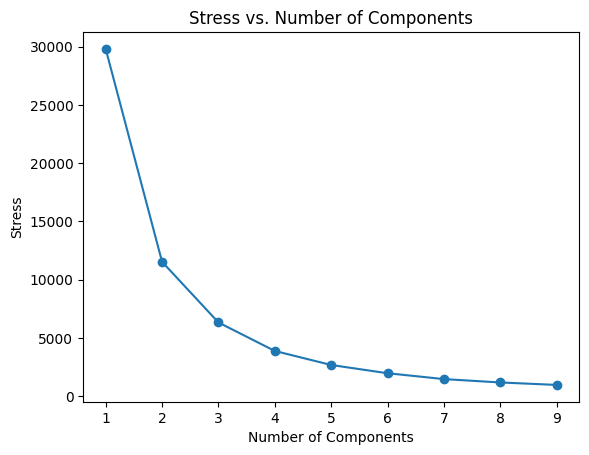

In [11]:
stresses = []
for n in range(1, 10):
    mds = MDS(n_components=n, dissimilarity="precomputed", random_state=42)
    mds.fit(D)
    stresses.append(mds.stress_)

plt.plot(range(1, 10), stresses, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Stress')
plt.title('Stress vs. Number of Components')
plt.show()

This is useful to reduce the number of dimensions (coordinates) in our analysis. The number of dimensions is the number of coordiantes that can be taken in order to compute our distances between data.The stress is an error measure. THe bigger the stress, the bigger the variability and error of the new model. If the stress is reduced, the model will be better (of course we have to take into account that simplicity of the model is important and that it has to be interpretable).
Notice that with 3 components, the stress is reduced a lot (from 30,000 to 5,000) so will be a very good approach between interpretability, simplicity and minimization of error.

Also taking more components don't reduce too much the stress, so it would not be worthwhile to do.

In [12]:
mds = MDS(n_components=3, dissimilarity="precomputed", random_state=42)
embedding = mds.fit_transform(D)

## 3.2. Heatmap

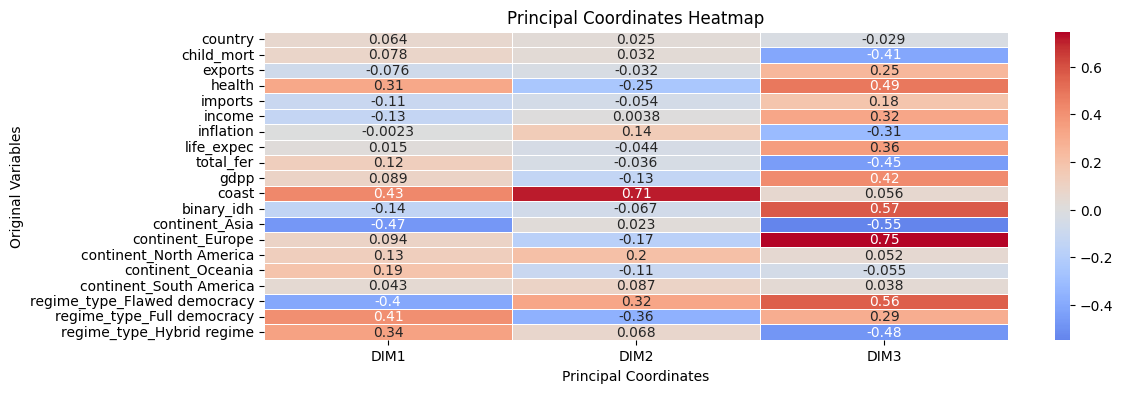

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.preprocessing import LabelEncoder

# Assuming 'df_trans' is your DataFrame with quantitative, binary, and multiclass columns

# Convert 'embedding' to a DataFrame
principal_coords = pd.DataFrame(embedding, columns=['DIM1', 'DIM2', 'DIM3'])

# Encode binary and multiclass (categorical) variables
le = LabelEncoder()
encoded_df = df_trans.copy()
for col in df_trans.select_dtypes(include=['object', 'category']).columns:
    encoded_df[col] = le.fit_transform(df_trans[col])

# Compute correlations/associations
correlation_table = []

for col in encoded_df.columns:
    correlations = []
    for pc in ['DIM1', 'DIM2', 'DIM3']:
        # Determine correlation method based on variable type
        if pd.api.types.is_numeric_dtype(encoded_df[col]):
            corr, _ = pearsonr(encoded_df[col], principal_coords[pc])
        else:
            corr, _ = spearmanr(encoded_df[col], principal_coords[pc])
        
        correlations.append(corr)
    correlation_table.append(correlations)

# Create a DataFrame for the correlation table
correlation_df = pd.DataFrame(correlation_table, columns=['DIM1', 'DIM2', 'DIM3'], index=encoded_df.columns)

# Plot the heatmap
plt.figure(figsize=(12, 4))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm', center=0, linewidths=0.5)

plt.title('Principal Coordinates Heatmap')
plt.xlabel('Principal Coordinates')
plt.ylabel('Original Variables')
plt.show()


This heat map allows to see the correlation between principal coordinates and variables, that is, shows the influence of original variables in the MDS. Notice that for the first coordinate there are not big correlations, being `coast`, `continent_Asia` and `regime_type_full_democracy` the most influential. But for example in the second one, `coast` has a very big influence, but the others don't have that much influence.
FInally, seeing the third one, the influence is bigger from all variables, specially `continent_Europe`.

## 3.3. Interpretation of MDS Dimensions

Based on the heatmap of correlations between the original variables and the MDS dimensions, we can summarize the interpretation as follows:

### DIM1
- **Positively Correlated With:**
  - **Coastline** (`coast`): Countries with coastlines tend to score higher on this dimension.
  - **Health Expenditure** (`health`): Higher health spending per capita aligns with higher DIM1 scores.
  - **Full Democracy** (`regime_type_Full democracy`).

- **Negatively Correlated With:**
  - **Asia** (`continent_Asia`): Asian countries tend to score lower on DIM1.
  - **Flawed Democracy** (`regime_type_Flawed democracy`).

### DIM2
- **Positively Correlated With:**
  - **Coastline** (`coast`): Strong association with countries having coastlines.
  - **Europe** (`continent_Europe`): European countries tend to score higher on DIM2.

- **Negatively Correlated With:**
  - **Full Democracy** (`regime_type_Full democracy`).
  - **Hybrid Regime** (`regime_type_Hybrid regime`).

### DIM3
- **Positively Correlated With:**
  - **Income** (`income`): Higher national income aligns with higher DIM3 scores.
  - **GDP per Capita** (`gdpp`): Wealthier countries score higher on this dimension.
  - **Health Expenditure** (`health`): Increased health spending per capita.
  - **Human Development Index** (`binary_idh`).

- **Negatively Correlated With:**
  - **Child Mortality** (`child_mort`): Higher child mortality rates lead to lower DIM3 scores.
  - **Fertility Rate** (`total_fer`): Countries with higher fertility rates score lower on this dimension.


## 3.4. Interpretation of the MDS Plots

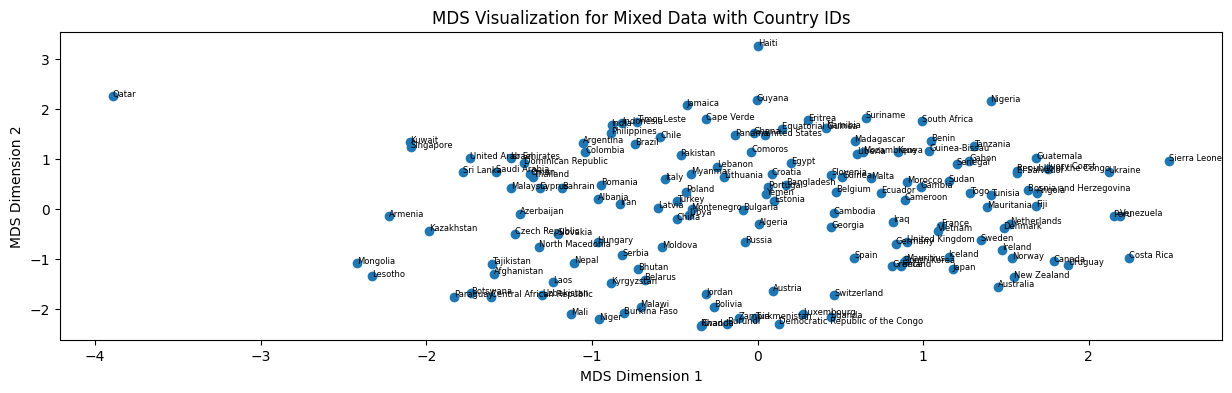

In [14]:
# Extract country names from df_trans
country_names = df_trans['country']

# Visualize with country IDs
plt.figure(figsize=(15, 4))
plt.scatter(embedding[:, 0], embedding[:, 1])

# Add country IDs with smaller font size
for i, country in enumerate(country_names):
    plt.text(embedding[i, 0], embedding[i, 1], country, fontsize=6)

plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('MDS Visualization for Mixed Data with Country IDs')
plt.show()

### DIM1 vs DIM2
- **Higher DIM1 Scores**:
  - Countries with **coastlines** and **higher health expenditure** tend to score higher.
  - Examples: **Singapore**, **Kuwait**.

- **Lower DIM1 Scores**:
  - Often associated with **Asian countries** or countries with a **flawed democracy regime**.
  - Examples: **Mongolia**, **Lesotho**.

- **Higher DIM2 Scores**:
  - Reflect countries with a **coastline** and those located in **Europe**.
  - Examples: **France**, **Netherlands**.



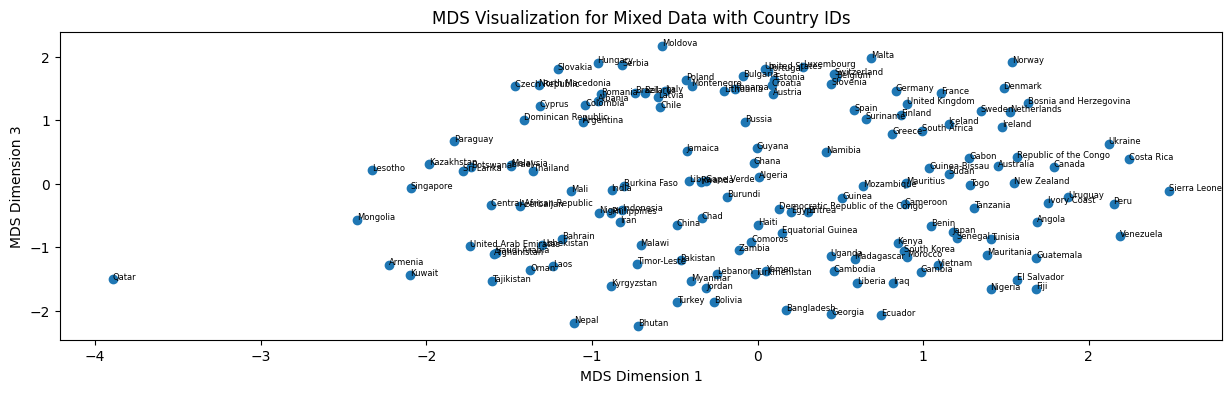

In [15]:
# Extract country names from df_trans
country_names = df_trans['country']

# Visualize with country IDs
plt.figure(figsize=(15, 4))
plt.scatter(embedding[:, 0], embedding[:, 2])

# Add country IDs with smaller font size
for i, country in enumerate(country_names):
    plt.text(embedding[i, 0], embedding[i, 2], country, fontsize=6)

plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 3')
plt.title('MDS Visualization for Mixed Data with Country IDs')
plt.show()

### DIM1 vs DIM3
- **Higher DIM3 Scores**:
  - Associated with **wealthier, more developed countries** with higher income and health expenditure.
  - Examples: **Norway**, **United States**.

- **Lower DIM3 Scores**:
  - Indicate countries with **higher child mortality** and **higher fertility rates**.
  - Examples: **Haiti**, **Niger**.

- This plot shows a **development gradient**, with:
  - Developed countries positioned in the **top-right**.
  - Less-developed countries positioned in the **bottom-left**.


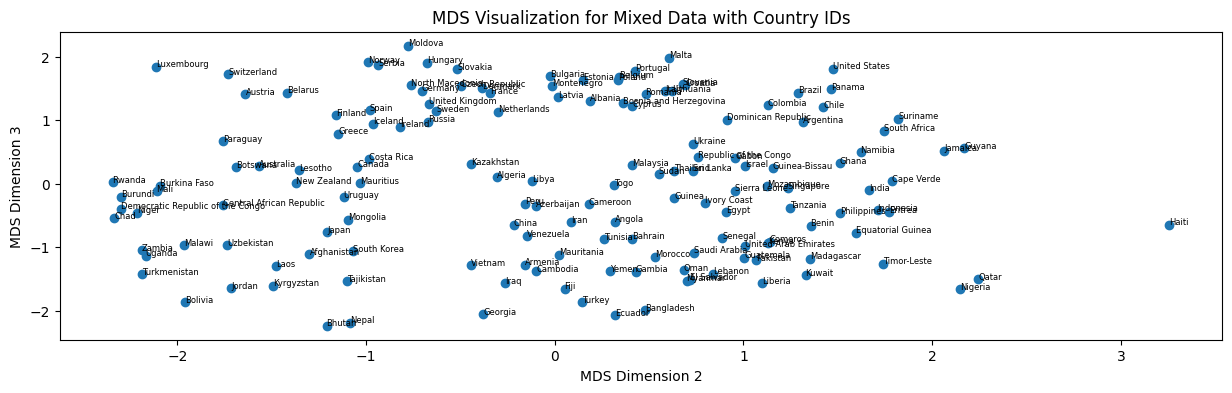

In [16]:
# Extract country names from df_trans
country_names = df_trans['country']

# Visualize with country IDs
plt.figure(figsize=(15, 4))
plt.scatter(embedding[:, 1], embedding[:, 2])

# Add country IDs with smaller font size
for i, country in enumerate(country_names):
    plt.text(embedding[i, 1], embedding[i, 2], country, fontsize=6)

plt.xlabel('MDS Dimension 2')
plt.ylabel('MDS Dimension 3')
plt.title('MDS Visualization for Mixed Data with Country IDs')
plt.show()

### DIM2 vs DIM3
- **Higher DIM3 Scores**:
  - Represent countries with **higher GDP per capita, higher health spending**, and better development indicators.

- **Higher DIM2 Scores**:
  - Associated with **coastal countries** and those in **Europe**.
  - Examples: **France**, **Netherlands**.

### DIM2 vs DIM3:
  - **Qatar** and **Haiti** stand out due to their unique combinations of variables:
    - **Qatar**: High GDP per capita but different health and demographic metrics.
    - **Haiti**: Low development indicators and high child mortality rates.

## 3.5. Explained variability

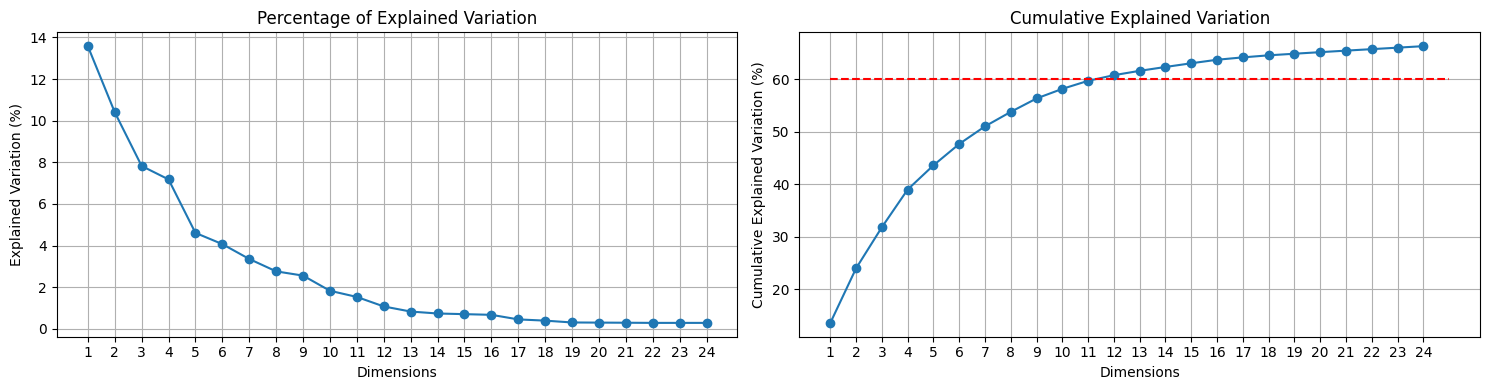

In [17]:
# Step 2: Convert dissimilarity matrix to Gram (inner product) matrix using double centering
n = D.shape[0]
H = np.eye(n) - np.ones((n, n)) / n  # Centering matrix
G = -0.5 * H @ (D**2) @ H  # Gram matrix

# Step 3: Eigenvalue decomposition
eigenvalues, eigenvectors = np.linalg.eigh(G)
eigenvalues = np.sort(eigenvalues)[::-1]  # Sort eigenvalues in descending order

# Ensure that all eigenvalues are non-negative. Numerical precision errors may cause small negative values
eigenvalues[eigenvalues < 0] = 0

# Step 4: Calculate explained variance
explained_variance = eigenvalues / np.sum(eigenvalues) * 100
cumulative_variance = np.cumsum(explained_variance)

# Step 5: Plot explained variance and cumulative variance
plt.figure(figsize=(15, 4))

# Explained Variance
plt.subplot(1, 2, 1)
plt.plot(range(1, 25), explained_variance[:24], marker='o')
plt.title("Percentage of Explained Variation")
plt.xlabel("Dimensions")
plt.ylabel("Explained Variation (%)")
plt.xticks(range(1, 25))
plt.grid()

# Cumulative Variance
plt.subplot(1, 2, 2)
plt.plot(range(1, 25), cumulative_variance[:24], marker='o')
plt.hlines(y=60, xmin=1, xmax=25, color='r', linestyles='--', label='60% Explained Variation')
plt.title("Cumulative Explained Variation")
plt.xlabel("Dimensions")
plt.ylabel("Cumulative Explained Variation (%)")
plt.grid()
plt.xticks(range(1, 25))
plt.tight_layout()
plt.show()

## 3.6. Influence RelMS

In [18]:
import numpy as np
from sklearn.manifold import MDS
from scipy.spatial import procrustes

# Original dataset
X = df_trans[quantitative_columns + binary_columns + new_multiclass_columns]

# Compute the original dissimilarity matrix and MDS configuration


mds = MDS(n_components=3, dissimilarity="precomputed", random_state=42)
embedding = mds.fit_transform(D)


# Function to compute the influence of each variable
def compute_influence(X, quantitative_columns, binary_columns, new_multiclass_columns):
    influences = []
    for col in X.columns:
        # Drop the current variable
        X_dropped = X.drop(columns=[col])
        
        # Recompute the dissimilarity matrix and MDS embedding
        D_dropped = relms_dist_matrix.compute(X_dropped)
        embedding_dropped = mds.fit_transform(D_dropped)
        
        # Align embeddings using Procrustes analysis
        _, _, disparity = procrustes(embedding, embedding_dropped)
        
        influences.append((col, disparity))
    
    return influences

# Calculate influences
influences = compute_influence(X, quantitative_columns, binary_columns, new_multiclass_columns)

# Display results
for col, influence in influences:
    print(f"Variable: {col}, Influence (Procrustes Distance): {influence:.4f}")


Variable: child_mort, Influence (Procrustes Distance): 0.2029
Variable: exports, Influence (Procrustes Distance): 0.2428
Variable: health, Influence (Procrustes Distance): 0.2387
Variable: imports, Influence (Procrustes Distance): 0.2105
Variable: income, Influence (Procrustes Distance): 0.2697
Variable: inflation, Influence (Procrustes Distance): 0.1809
Variable: life_expec, Influence (Procrustes Distance): 0.1691
Variable: total_fer, Influence (Procrustes Distance): 0.1617
Variable: gdpp, Influence (Procrustes Distance): 0.2019
Variable: binary_idh, Influence (Procrustes Distance): 0.1887
Variable: coast, Influence (Procrustes Distance): 0.8545
Variable: regime_type_Full democracy, Influence (Procrustes Distance): 0.6530
Variable: regime_type_Flawed democracy, Influence (Procrustes Distance): 0.5051
Variable: continent_Oceania, Influence (Procrustes Distance): 0.1997
Variable: continent_North America, Influence (Procrustes Distance): 0.0271
Variable: continent_Europe, Influence (Proc

This code aims to measure the **influence of each variable** in the dataset on the **Multidimensional Scaling (MDS)** configuration by systematically excluding each variable and assessing how the MDS results change. For each variable in the dataset, the code temporarily **removes** that variable, recalculates the dissimilarity matrix without it, and generates a new MDS embedding. To quantify the impact of excluding the variable, the **Procrustes analysis** is applied to align the new embedding with the original one, producing a **disparity measure** (distance) that reflects the difference between the two embeddings. This disparity is recorded as the **influence score** for that variable. The greater the disparity, the more the variable influences the overall MDS configuration. 

As can be seen, the continuous variables have similar influence, but there are two categorical varaibles pushing more than others.

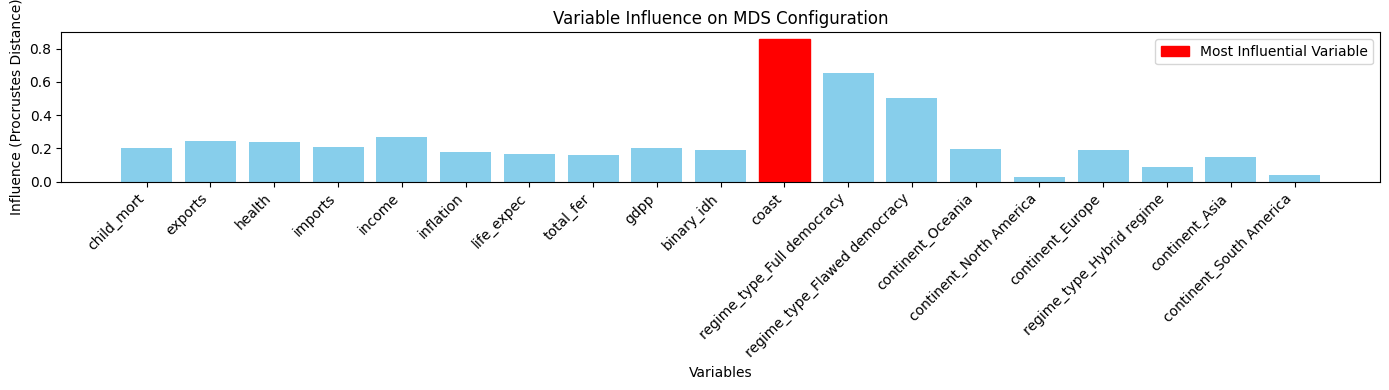

In [19]:
# Extract variable names and influence values
variables = [item[0] for item in influences]
influence_values = [item[1] for item in influences]

# Plot the influences
plt.figure(figsize=(14, 4))
bars = plt.bar(variables, influence_values, color='skyblue')

# Highlight the most influential variable
max_influence = max(influence_values)
max_index = influence_values.index(max_influence)
bars[max_index].set_color('red')

# Update the legend to reflect the red color
plt.legend([bars[max_index]], ['Most Influential Variable'], loc='upper right')

# Customize plot appearance
plt.xlabel('Variables')
plt.ylabel('Influence (Procrustes Distance)')
plt.title('Variable Influence on MDS Configuration')
plt.xticks(rotation=45, ha='right', fontsize=10)  # Rotate and align labels
plt.tight_layout()  # Adjust layout to prevent clipping

# Show the plot
plt.show()


## 3.7. Continuous variables conditional scatterplots

As we have 9 continuous variables in total, we can't add all the conditional scatterplots in the different dimensions due to a space limit matter. We are going to plot 2 of them as an example.

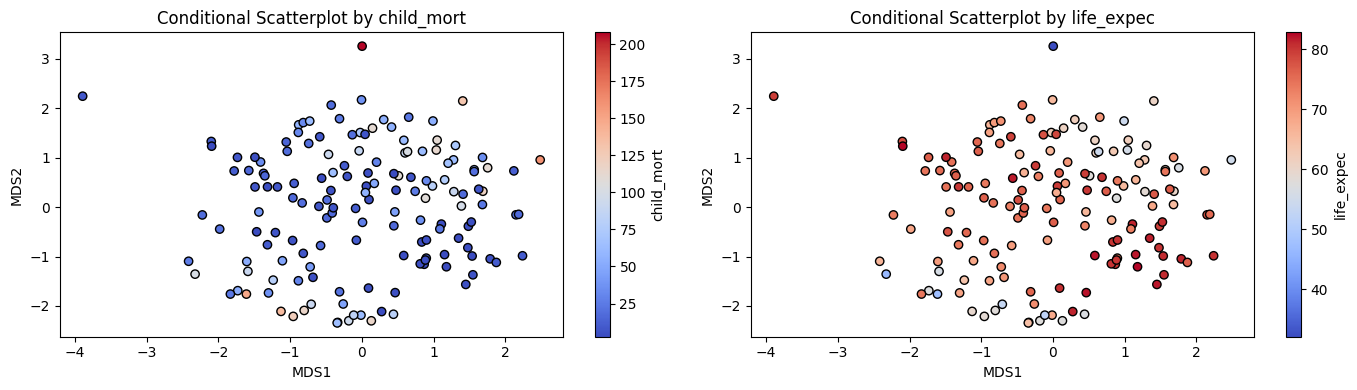

In [20]:
# Add the MDS coordinates to the DataFrame
X['MDS1'] = embedding[:, 0]
X['MDS2'] = embedding[:, 1]
X['MDS3'] = embedding[:, 2]

# Create conditional scatterplots
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

scatter1 = axes[0].scatter(X['MDS1'], X['MDS2'], c=X['child_mort'], cmap='coolwarm', edgecolor='k')
axes[0].set_title('Conditional Scatterplot by child_mort')
axes[0].set_xlabel('MDS1')
axes[0].set_ylabel('MDS2')
fig.colorbar(scatter1, ax=axes[0], label='child_mort')

scatter2 = axes[1].scatter(X['MDS1'], X['MDS2'], c=X['life_expec'], cmap='coolwarm', edgecolor='k')
axes[1].set_title('Conditional Scatterplot by life_expec')
axes[1].set_xlabel('MDS1')
axes[1].set_ylabel('MDS2')
fig.colorbar(scatter2, ax=axes[1], label='life_expec')


# Show the plot
plt.tight_layout()
plt.show()

### 3.7.1. Analysis of Conditional Scatterplots

The conditional scatterplots reveal how the **MDS configuration** is influenced by specific variables, particularly **child mortality** and **life expectancy**. Both scatterplots demonstrate comparable structural changes in the MDS embedding, emphasizing the importance of these variables in distinguishing countries based on **health outcomes** and **development levels**.

When conditioning on **child mortality**, countries with **high child mortality rates** tend to cluster in regions **away from the central stable cluster**. This indicates that high child mortality significantly influences the structure of the MDS configuration, causing these countries to occupy more distinct positions. In contrast, countries with **low child mortality rates** remain situated **closer to the central cluster**, reflecting greater stability and similarity with each other.

Similarly, when the scatterplot is conditioned on **life expectancy**, a nearly identical pattern emerges. Countries with **low life expectancy** — which often corresponds to high child mortality — are positioned **outside the central cluster**, indicating their distinctiveness in the embedding. Conversely, countries with **high life expectancy** tend to cluster within the **stable core** of the plot, suggesting more consistent development and health outcomes.

The comparison of these two scatterplots highlights the **inverse relationship** between child mortality and life expectancy. Countries with **high child mortality** generally have **low life expectancy**, while those with **low child mortality** tend to have **high life expectancy**. This inverse relationship means that both variables exert a **similar influence** on the MDS configuration, capturing the same underlying dimension of **health and development**. As a result, these variables are crucial in differentiating countries based on their health-related characteristics.




## 3.8. Categorical variables conditional scatterplots

As before, due to space issues, only two categories are going to be plotted. 

In [21]:
# Create a DataFrame with embedding and continent column
embedding_df = pd.DataFrame(embedding, columns=['Dimension 1', 'Dimension 2', 'Dimension 3'])
embedding_df['continent'] = df['continent']
embedding_df['Country'] = df['country'].tolist()

embedding_df['coast'] = df['coast']


fig = px.scatter(
    embedding_df,
    x='Dimension 1',
    y='Dimension 2',
    color='coast',  # Color by coast
    title='MDS Plot by coast',
    labels={'color': 'coast'}, 
    hover_name='coast'  
)
fig.show()


fig = px.scatter(
    embedding_df,
    x='Dimension 1',
    y='Dimension 3',
    color='continent',  # Color by continent
    title='MDS Plot by Continent',
    labels={'color': 'Continent'}, 
    hover_name='Country'  
)
fig.show()

The two conditional scatterplots illustrate how the **MDS** configuration with different categorical variables, specifically **coastline presence** and **continent**. Although these scatterplots are plotted in different dimensions, they reveal consistent patterns of separation and clustering, providing insight into how these factors influence the structure of the MDS embedding.

In the first scatterplot, conditioned on **coastline presence**, the points are plotted in **Dimensions 1 and 2**. Countries with a **coastline** (marked in red) tend to be positioned **above the horizontal axis** (Dimension 2 > 0), while countries **without a coastline** (marked in blue) are primarily located **below the horizontal axis** (Dimension 2 < 0). This distinct vertical separation indicates that **Dimension 2** captures the influence of coastline presence, suggesting that having or not having a coast significantly differentiates countries along this dimension.

In the second scatterplot, conditioned on **continent**, the points are plotted in **Dimensions 1 and 3**. Countries from different continents exhibit clear vertical separation along **Dimension 3**. For example, countries from **Europe** (red) are clustered toward the **upper region** (Dimension 3 > 0), while countries from **Africa** (green) are generally located in the **lower region** (Dimension 3 < 0). Other continents, such as **Asia** (purple), **North America** (cyan), **South America** (purple), and **Oceania** (orange), display unique clustering patterns, highlighting that **Dimension 3** effectively captures geographical distinctions.

## 3.9. Stability


This code performs a **stability analysis** on a Multidimensional Scaling (MDS) configuration using a technique called **Jackknife Resampling**. The objective is to understand how **removing each individual data point** affects the overall MDS configuration, helping to assess the **stability** of the configuration and identify any points that might have a disproportionate influence.

### Process Breakdown

1. **Original MDS Configuration**:  
   - We use the **original MDS configuration emmbedding** as the **reference configuration**.

2. **Jackknife Resampling**:  
   - The Jackknife technique iteratively **leaves out one data point** at a time.  
   - For each iteration:  
     - The dataset is reduced by **excluding one data point**.  
     - A **new dissimilarity matrix** is computed for the reduced dataset.  
     - A new **MDS embedding** is generated using the reduced dataset.  
     - The new embedding is then **aligned** with the original embedding using **Procrustes analysis**.  
       Procrustes analysis adjusts the new embedding to match the original one as closely as possible through **scaling, rotation, and translation**.

3. **Reinserting the Excluded Point**:  
   - After aligning the reduced embedding, the excluded data point's position from the original embedding is **inserted back** into the aligned embedding.  
   - This results in a complete embedding for each iteration of the Jackknife resampling.

4. **Measuring Variability**:  
   - For each data point, the **average distance** (or variability) between its position in the original embedding and its positions in the Jackknife resampled embeddings is calculated.  
   - This variability quantifies the **sensitivity** of each data point to the removal of other points.

5. **Visualization with Variability Circles**:  
   - The original MDS configuration is plotted, with each data point displayed along with a **circle** representing its variability.  
   - The **size of the circle** indicates the variability:  
     - **Larger circles** signify higher sensitivity and potential **instability**.  
     - Points with large circles may be **influential points** or **outliers** that disproportionately affect the configuration.


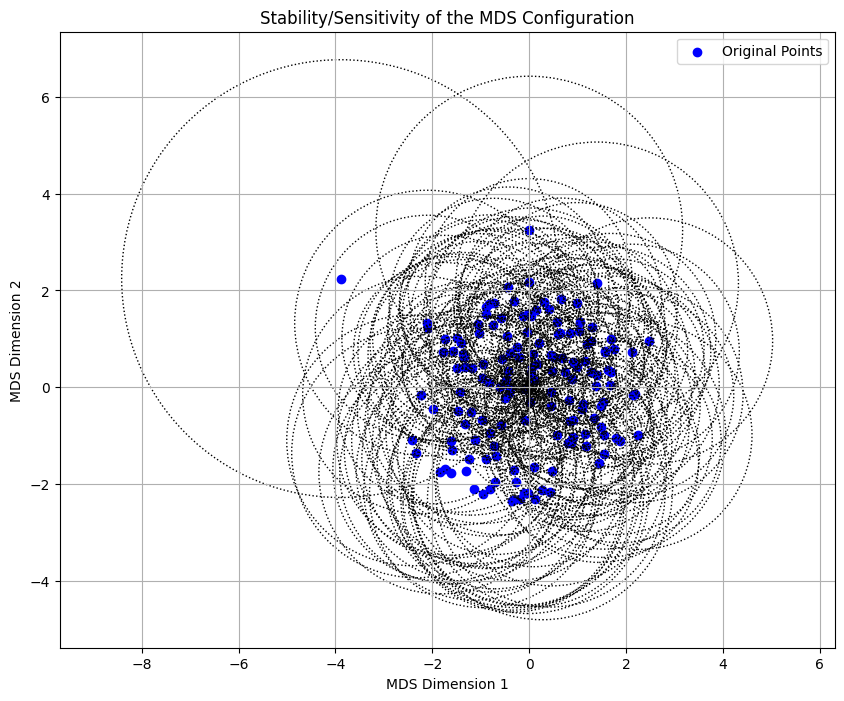

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
from scipy.spatial import procrustes

# Load your dataset (replace this with actual data)
data = df_trans[quantitative_columns + binary_columns + new_multiclass_columns]

# Compute the original dissimilarity matrix


# Compute the original MDS configuration with a fixed random state
mds = MDS(n_components=3, dissimilarity='precomputed', random_state=42)
embedding_original = mds.fit_transform(D)

# Jackknife resampling to assess sensitivity
n_samples = data.shape[0]
jackknife_embeddings = []

for i in range(n_samples):
    # Leave out the i-th sample
    data_jackknife = np.delete(data, i, axis=0)
    
    # Compute the dissimilarity matrix for the reduced dataset
    D_jackknife = relms_dist_matrix.compute(X=data_jackknife)
    
    # Compute MDS for the reduced dataset with the same random state
    embedding_jackknife = mds.fit_transform(D_jackknife)
    
    # Align the reduced embedding with the original embedding
    embedding_aligned, _, _ = procrustes(embedding_original[np.arange(n_samples) != i], embedding_jackknife)
    
    # Insert the excluded point's original embedding back into the aligned embedding
    embedding_with_insert = np.insert(embedding_aligned, i, embedding_original[i], axis=0)
    jackknife_embeddings.append(embedding_with_insert)

# Compute variability for each point
variability = np.zeros(n_samples)
for i in range(n_samples):
    diffs = [np.linalg.norm(embedding_original[i] - emb[i]) for emb in jackknife_embeddings]
    variability[i] = np.mean(diffs)

# Plot the original MDS configuration with variability circles
plt.figure(figsize=(10, 8))
plt.scatter(embedding_original[:, 0], embedding_original[:, 1], c='blue', label='Original Points')

# Add circles representing variability
for i in range(n_samples):
    circle = plt.Circle((embedding_original[i, 0], embedding_original[i, 1]), variability[i], color='black', fill=False, linestyle='dotted')
    plt.gca().add_patch(circle)

plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title(f'Stability/Sensitivity of the MDS Configuration')
plt.grid(True)
plt.legend()
plt.axis('equal')
plt.show()

### 3.9.1. Analysis of the Stability

The MDS configuration shown in the plot provides valuable insights into the **stability** of the embedding. The plot displays the original points in blue, with **dotted circles** representing the variability for each point. This variability reflects how sensitive each point's position is to the removal of other data points during the **Jackknife Resampling** process. The plot highlights that while the overall MDS configuration is **reasonably stable**, certain points exhibit **high sensitivity**. These high-variability points could be key to understanding unique patterns or **outlying behavior** in the dataset. 

1. **Central Cluster**:
   - The majority of points are tightly clustered around the center of the plot, indicating that their variability is relatively low.
   - The smaller circles surrounding these points suggest that the positions of these points are **stable** and not significantly affected by the removal of other points.

2. **High Variability Points**:
   - There are several points with notably **large circles**, particularly on the **edges and outskirts** of the cluster.
   - These points exhibit high variability, indicating they are more **sensitive** to the exclusion of other points. They may represent **outliers** or countries with unique characteristics that influence the MDS configuration disproportionately.

3. **Outliers**:
   - A few points, such as the ones located at the **far left** and **upper region** of the plot, are clearly separated from the central cluster and have **large variability circles**.
   - These outliers contribute to the overall structure of the embedding and may be driving some of the patterns observed in the MDS configuration.

4. **Dense Overlap**:
   - The overlapping circles in the dense central region indicate that while most points are stable, there is still some level of variability within the main cluster.
   - This suggests that the **similarities** between countries in this region are robust but not entirely fixed, and small perturbations can shift their positions slightly.





# 4. Clustering

## 4.1. Hierarchical clustering

We are performing hierarchical clustering on a dataset containing mixed data types (numerical and categorical) and correlated features. Due to the nature of the data, we cannot rely on the standard Euclidean distance measure, as it assumes numerical data and independent features. Instead, we constructed a precomputed distance matrix using the mixed distance method used before.

For the hierarchical clustering process, we selected the average linkage criterion. The main reasons for this choice are:

1. Resistance to Outliers:
    Average linkage computes the distance between clusters as the average pairwise distance between all points in the two clusters. Unlike single linkage, which is highly sensitive to outliers due to its reliance on the minimum distance, or complete linkage, which can exaggerate the influence of outliers due to its reliance on the maximum distance, average linkage provides a balanced approach. This makes it more robust to the presence of outliers in the data.

2. Flexibility in Cluster Shape:
    Average linkage does not overly constrain clusters to be compact (as in complete linkage) or elongated (as in single linkage). This flexibility allows it to handle data with varying cluster shapes and sizes, which is particularly useful when working with mixed data types.

In [23]:
country_labels = df_trans['country'].tolist()
D = np.trunc(D * 10_00) / 10_00
D_condensed = squareform(D)

Z = linkage(D_condensed, method='complete')

The dendrogram visually shows hierarchical clustering results. Each branch represents a cluster, and the height of the branch corresponds to the distance (dissimilarity) between clusters. The plot reveals significant clustering at lower distances, with a few branches separating at much larger distances.

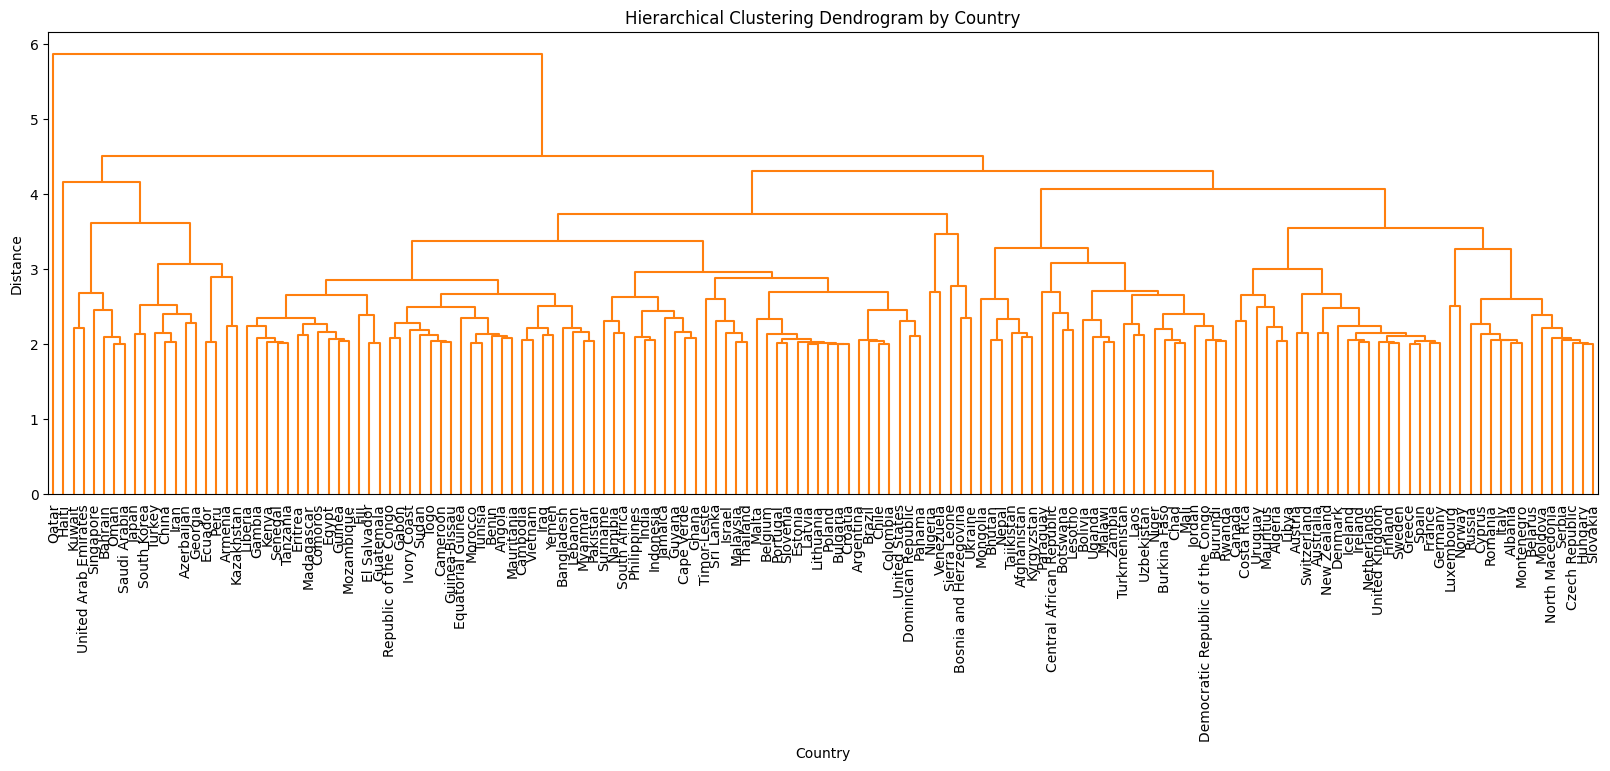

In [24]:
plt.figure(figsize=(20, 6))
dendrogram(Z, labels=country_labels, leaf_rotation=90, leaf_font_size=10, color_threshold=6)
plt.title('Hierarchical Clustering Dendrogram by Country')
plt.xlabel('Country')
plt.ylabel('Distance')
#plt.axhline(y=1.7, color='r', linestyle='--')
plt.show()

We are going to use **Mardia et al. (1989)** to decide the appropiate number of clusters. 

$$
n_{clusters} = \frac{\sqrt{n}}{2} = 6.1644 \approx 6
$$

In [25]:
n_clusters = math.floor(math.sqrt(df_trans.shape[0])/2)  # Desired number of clusters
clusters = fcluster(Z, t=n_clusters, criterion='maxclust')

df_trans['cluster'] = clusters
#print(df_trans[['country', 'cluster']])
df_trans['cluster'].value_counts()

cluster
3    72
5    36
4    25
1    17
2     1
6     1
Name: count, dtype: int64

The clusters are highly unbalanced, with most data points grouped into a few large clusters (e.g., cluster 3 with 72 points) and some clusters containing very few points (e.g., clusters 2 and 6). We conclude that this method resulted in an unbalanced cluster distribution, suggesting that the chosen number of clusters may be insufficient to reflect the underlying data structure adequately.

To address the imbalance, we will use a distance threshold. We inspected the dendrogram to select a distance threshold. The threshold determines where to "cut" the dendrogram to form clusters. A lower threshold creates smaller clusters, while a higher threshold creates larger clusters. In this case, the choice of the threshold was guided by:

* Visual Gaps: Identifying significant gaps in branch heights to naturally split the data into meaningful clusters.
* Purpose Flexibility: Since no specific objective was defined for clustering, a more balanced cluster distribution was preferred.

We defined a threshold of 2.55.

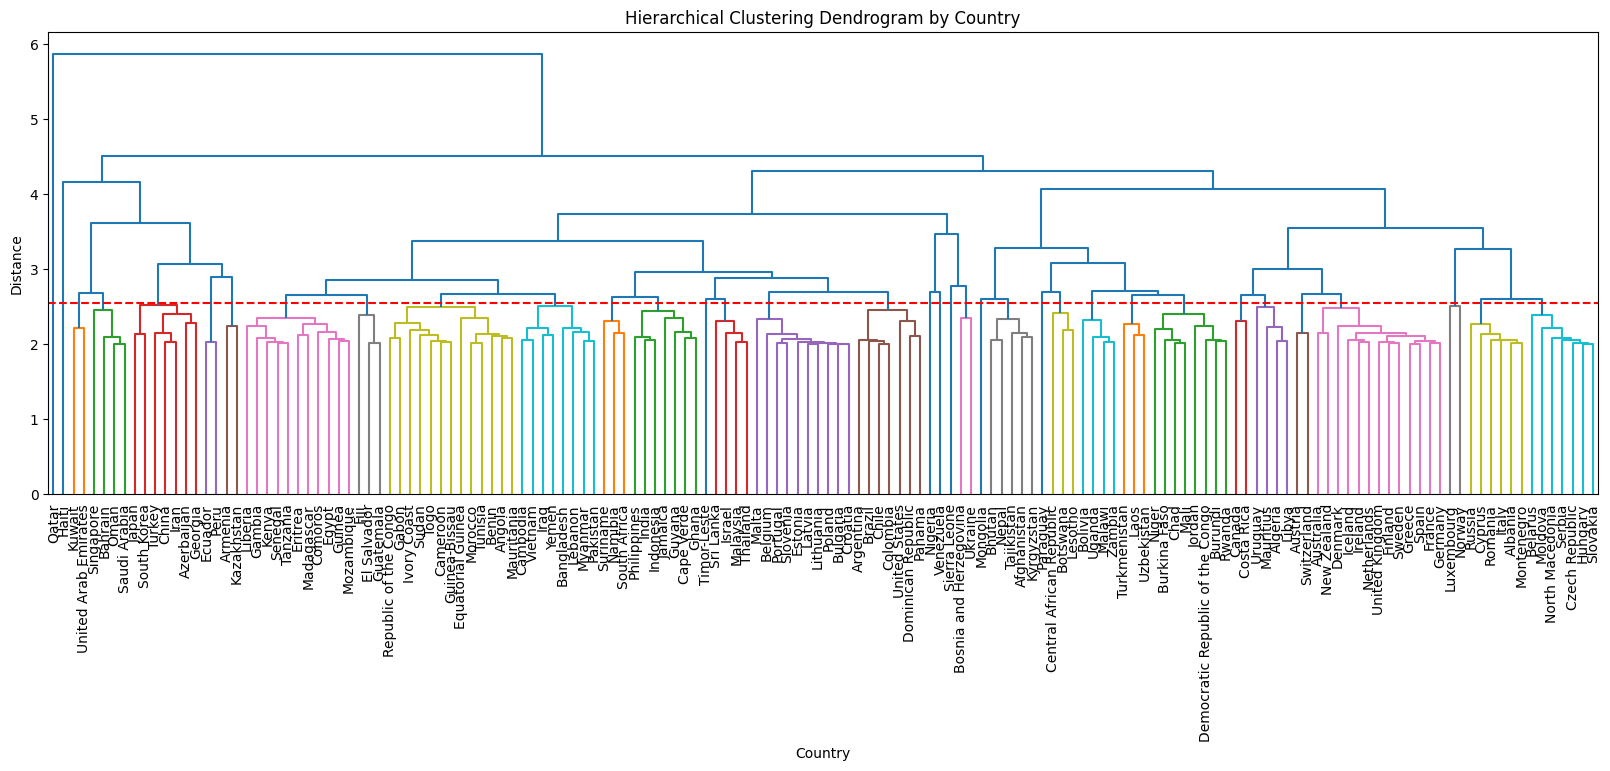

In [26]:
plt.figure(figsize=(20, 6))
dendrogram(Z, labels=country_labels, leaf_rotation=90, leaf_font_size=10, color_threshold=2.55)
plt.title('Hierarchical Clustering Dendrogram by Country')
plt.xlabel('Country')
plt.ylabel('Distance')
plt.axhline(y=2.55, color='r', linestyle='--')
plt.show()

## 4.2. K-Medoids

We selected k-medoids clustering as the non-hierarchical method for partitioning the dataset into k clusters. The decision was driven by the following considerations:

* Suitability for Non-Euclidean Distances:
Unlike k-means, which relies on the Euclidean distance and assumes numerical data, k-medoids is flexible and allows the use of arbitrary dissimilarity measures. This flexibility is essential because our dataset contains mixed data types (numerical and categorical features), requiring custom distance metrics such as Gower's distance and Relative Mahalanobis Similarity.

* Robustness to Outliers:
The medoid, which is the most centrally located point within a cluster, minimizes the average dissimilarity to all other points in the cluster. Unlike centroids in k-means, medoids are actual data points and are less sensitive to outliers or extreme values.

We initially used RelMSDistMatrix as in the previous sections, but the optimal number of clusters obtained using the silhouette score was 2. This result was not satisfactory, as it did not capture the underlying data structure effectively. Then we decided to compare the silhouette score for the RelMSDistMatrix and the Gower distance to decide which method was a better fit for our data.

In [27]:
D_RelMS = D 
D_Gower = ggower_dist_matrix.compute(X=df_trans[quantitative_columns + binary_columns + new_multiclass_columns])

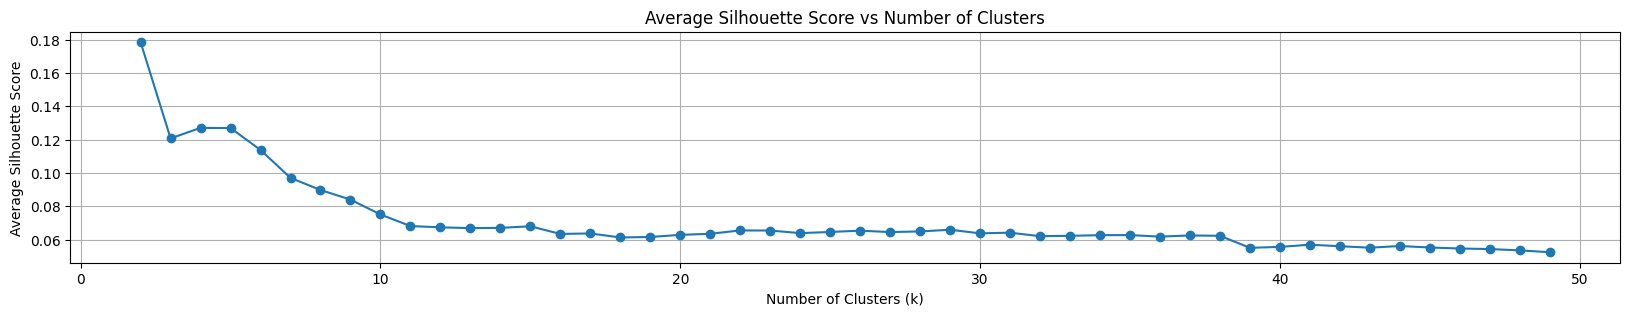

The optimal number of clusters is: 2. With a silhouette score of: 0.178


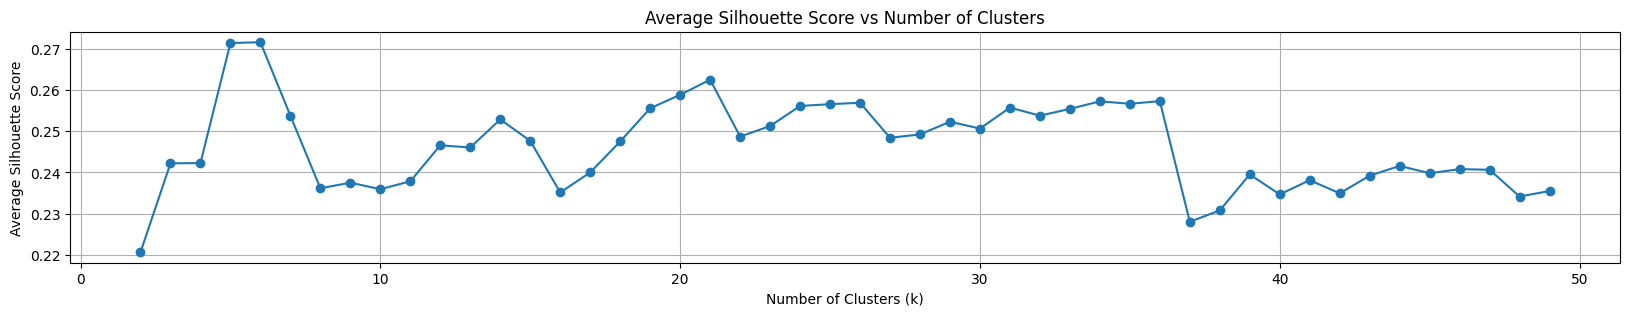

The optimal number of clusters is: 6. With a silhouette score of: 0.272


In [28]:
# Function to run K-Medoids with precomputed distance matrix
def run_kmedoids(distance_matrix, n_clusters, n_points):
    # Random initialization of medoids
    np.random.seed(42)
    initial_medoids = np.random.choice(range(n_points), n_clusters, replace=False)
    kmedoids_instance = kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()
    
    # Retrieve clusters and medoids
    clusters = kmedoids_instance.get_clusters()
    medoids = kmedoids_instance.get_medoids()
    
    # Sort clusters by medoid indices for consistency
    sorted_clusters = [clusters[i] for i in np.argsort(medoids)]
    
    # Assign consistent cluster labels
    labels = np.zeros(n_points)
    for cluster_id, cluster_points in enumerate(sorted_clusters):
        for point in cluster_points:
            labels[point] = cluster_id
    return labels

def run_silhouette_analysis(D):
    n_points = D.shape[0]

    # Range of clusters to evaluate
    range_n_clusters = range(2, 50)

    # List to store silhouette scores
    silhouette_avg_scores = []

    # Loop through each number of clusters and compute silhouette score
    for n_clusters in range_n_clusters:
        # Run K-Medoids clustering
        labels = run_kmedoids(D, n_clusters, n_points)
        
        # Calculate the silhouette score
        silhouette_avg = silhouette_score(D, labels, metric='precomputed')
        silhouette_avg_scores.append(silhouette_avg)
        #print(f"For n_clusters = {n_clusters}, silhouette score = {silhouette_avg:.3f}")

    # Plot the silhouette scores
    plt.figure(figsize=(20, 3))
    plt.plot(range_n_clusters, silhouette_avg_scores, marker='o')
    plt.title("Average Silhouette Score vs Number of Clusters")
    plt.xlabel("Number of Clusters (k)")
    plt.ylabel("Average Silhouette Score")
    plt.grid(True)
    plt.show()

    # Find the optimal number of clusters
    optimal_n_clusters = range_n_clusters[np.argmax(silhouette_avg_scores)]
    print(f"The optimal number of clusters is: {optimal_n_clusters}. With a silhouette score of: {max(silhouette_avg_scores):.3f}")

    return optimal_n_clusters, max(silhouette_avg_scores)
optimal_n_clusters_RelMS, best_silhouette_RelMS = run_silhouette_analysis(D_RelMS)
optimal_n_clusters_Gower, best_silhouette_Gower = run_silhouette_analysis(D_Gower)

As we can see, the silhouette score for the Gower distance is higher than the silhouette score for the RelMSDistMatrix. This result suggests that the Gower distance is more suitable for our dataset, as it captures the underlying data structure more effectively. Therefore, we will use the Gower distance for k-medoids clustering.

In [29]:
print(f"Optimal number of clusters for RelMS: {optimal_n_clusters_RelMS} with silhouette score: {best_silhouette_RelMS:.3f}")
print(f"Optimal number of clusters for Gower: {optimal_n_clusters_Gower} with silhouette score: {best_silhouette_Gower:.3f}")

Optimal number of clusters for RelMS: 2 with silhouette score: 0.178
Optimal number of clusters for Gower: 6 with silhouette score: 0.272


The silhouette plot visually evaluates the quality of clustering for the chosen optimal number of clusters. Each horizontal bar represents one cluster, and the length and position of the bars indicate how well the data points in each cluster are assigned. The silhouette coefficient values range from −1 to 1, where:

s(i)≈1: Data points are well-clustered and far from neighboring clusters.

s(i)≈0: Data points are on or near the boundary between clusters.

s(i)≈−1: Data points are likely misclassified and belong to neighboring clusters.

* The silhouette coefficients range from -0.05 to approximately 0.27, indicating moderate clustering quality.
* Positive values (right of zero) suggest that points are closer to their assigned cluster than to any other cluster.
* A few points have negative values (e.g., in clusters 0, 3, and 5), suggesting they may be misclassified or are near the boundary between clusters.
* The average silhouette score appears to be modest, indicating that while the clustering separates the data into meaningful groups, there may still be some overlap or ambiguity between certain clusters.

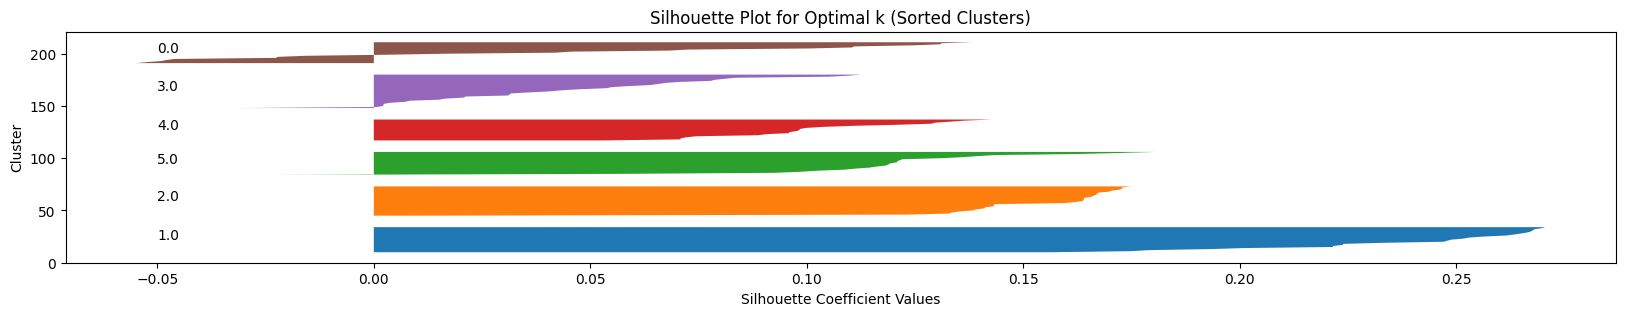

In [30]:

# Run K-Medoids clustering
n_points = D_Gower.shape[0]
final_labels = run_kmedoids(D, optimal_n_clusters_Gower, n_points)

# Compute silhouette values
silhouette_values = silhouette_samples(D, final_labels, metric='precomputed')

# Calculate the mean silhouette score for each cluster
cluster_means = {}
for cluster in np.unique(final_labels):
    cluster_means[cluster] = silhouette_values[final_labels == cluster].mean()

# Sort clusters by their mean silhouette score
sorted_clusters = sorted(cluster_means.keys(), key=lambda x: cluster_means[x], reverse=True)

# Plot the silhouette values in sorted order
plt.figure(figsize=(20, 3))
y_lower = 10
for i in sorted_clusters:  # Use the sorted cluster order
    ith_cluster_silhouette_values = silhouette_values[final_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))  # Original cluster label
    y_lower = y_upper + 10  # Space between clusters

plt.title("Silhouette Plot for Optimal k (Sorted Clusters)")
plt.xlabel("Silhouette Coefficient Values")
plt.ylabel("Cluster")
plt.show()


We can see how the amount of countries in each cluster is more balanced than in the hierarchical clustering. 

In [31]:
#country_labels
cluestered_countries = pd.DataFrame({'country': country_labels, 'cluster': final_labels})
cluestered_countries['cluster'].value_counts()

cluster
3.0    33
2.0    29
1.0    25
5.0    23
4.0    21
0.0    21
Name: count, dtype: int64

Let's plot the map of the world with the clusters to visually see the distribution of the countries.

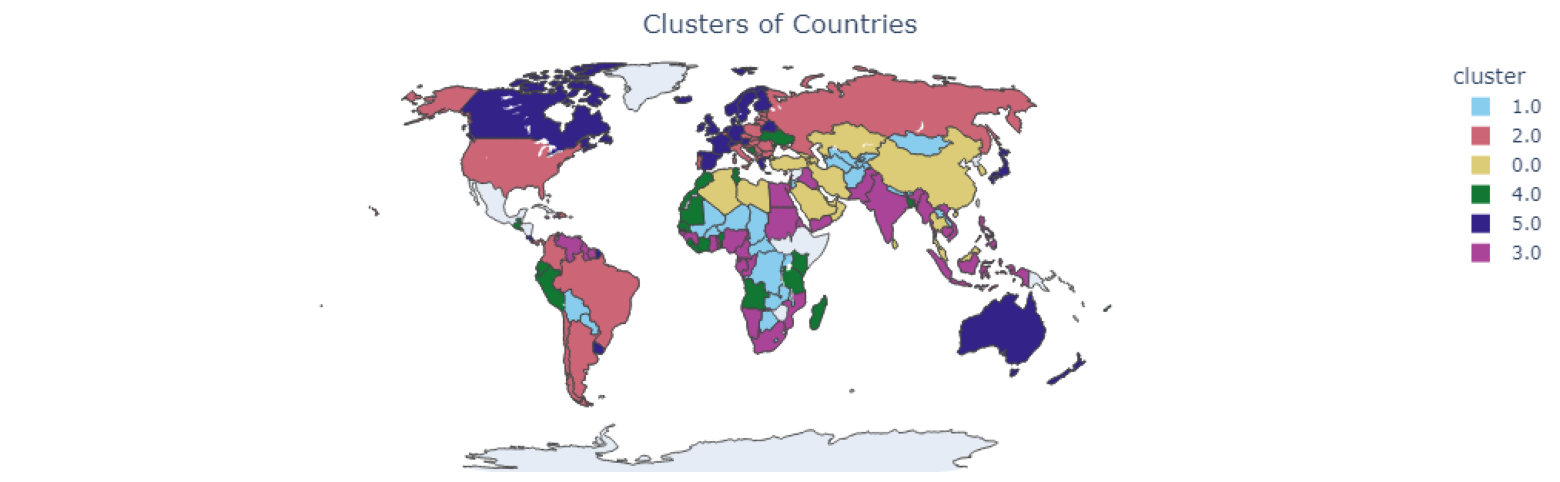

In [32]:
'''import plotly.express as px

# Create a dataframe with countries and clusters
cluestered_countries['cluster'] = cluestered_countries['cluster'].astype(str)

# Plot a choropleth map
fig = px.choropleth(cluestered_countries, 
                    locations='country', 
                    locationmode='country names', 
                    color='cluster',
                    title="Clusters of Countries",
                    color_discrete_sequence=px.colors.qualitative.Safe)
fig.update_layout(
    width=1000,  
    height=300,
    margin={"r":0, "t":30, "l":0, "b":0},  # Set margins: right, top, left, bottom
    geo=dict(
        showframe=False,          # Remove frame around the map
        projection_type='natural earth'  # A clean map projection
    ),
    title_x=0.5  # Center the title
)

fig.show()'''

image = mpimg.imread("mapa1.png")
plt.figure(figsize=(20, 6))
# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

Conclusions on the clusters:
1. Economic Development and GDP per Capita (gdpp, income, exports, imports)

* Developed countries such as North America, Western Europe, Australia, and Japan appear in the same cluster (e.g., purple). These regions likely exhibit high GDP per capita, high exports/imports, and strong health spending.
  
* Countries in Africa and parts of South Asia appear in distinct clusters (e.g., pink, light blue, and green), likely corresponding to lower GDP per capita.

Conclusion:
Economic prosperity plays a significant role in clustering. Countries with higher income, and trade openness form distinct clusters compared to those with lower economic development.

2. Child Mortality and Life Expectancy:
   * Countries in Africa (light blue and pink) and parts of South Asia stand out as belonging to clusters characterized by: 
     * High child mortality rates (child_mort).
     * Lower life expectancy (life_expec).
     * Higher fertility rates (total_fer).
  
   * In contrast, countries in Europe, North America, and Oceania (e.g., purple and red) exhibit:
     * Low child mortality rates.
     * High life expectancy, reflecting better healthcare systems and living conditions.

3.  Human Development Index (idh) and Coastal Access.
   * Regions such as Europe, Oceania, and parts of North America likely belong to clusters with a high HDI (idh), indicating better overall living conditions.
   * Landlocked countries (without coastlines) appear scattered in clusters with lower HDI and higher mortality rates (e.g., many countries in central Africa and parts of Asia (light blue)).

Conclusion:

Countries with high HDI tend to cluster together, highlighting strong human development and welfare systems. Coastal access (coast) may also contribute to trade openness (exports/imports) and economic performance, influencing cluster assignment.



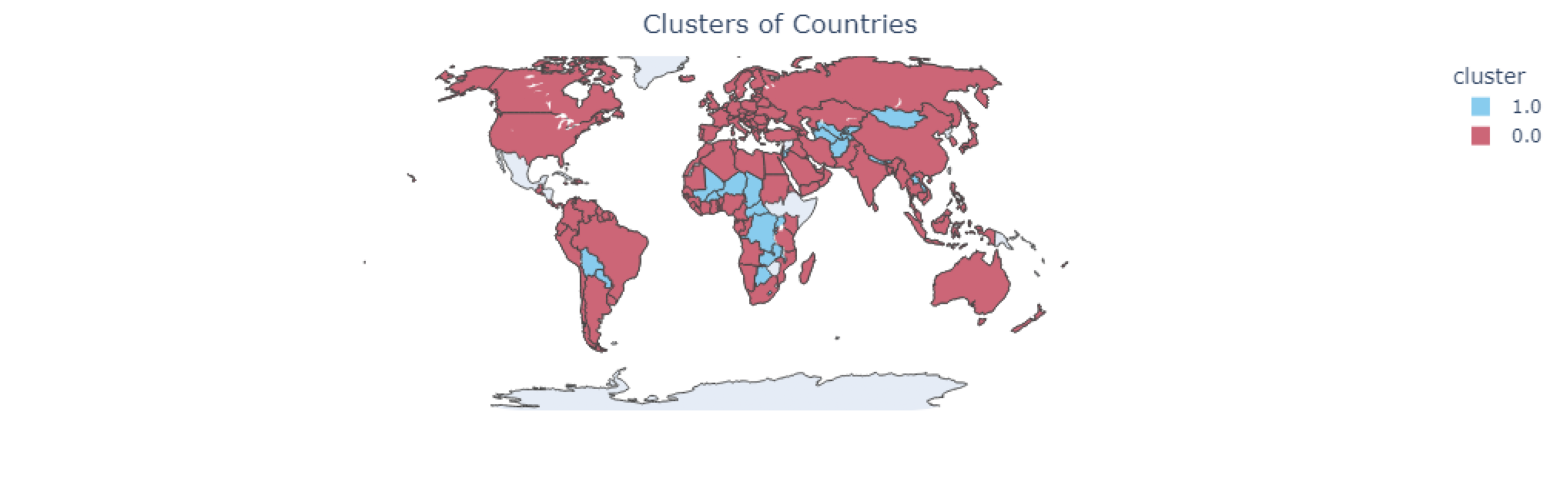

In [33]:
'''import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'notebook'
n_points = D_RelMS.shape[0]
final_labels = run_kmedoids(D, optimal_n_clusters_RelMS, n_points)

cluestered_countries = pd.DataFrame({'country': country_labels, 'cluster': final_labels})
cluestered_countries['cluster'] = cluestered_countries['cluster'].astype(str)

# Plot a choropleth map
fig = px.choropleth(cluestered_countries, 
                    locations='country', 
                    locationmode='country names', 
                    color='cluster',
                    title="Clusters of Countries",
                    color_discrete_sequence=px.colors.qualitative.Safe)

# Update layout to remove white space
fig.update_layout(
    width=1000,  
    height=300,
    margin={"r":0, "t":30, "l":0, "b":0},  # Set margins: right, top, left, bottom
    geo=dict(
        showframe=False,          # Remove frame around the map
        projection_type='natural earth'  # A clean map projection
    ),
    title_x=0.5  # Center the title
)

fig.show()'''


image = mpimg.imread("mapa2.png")
plt.figure(figsize=(20, 6))
# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()


We can compare the previous clustering results with those obtained using the RelMS distance. While the clustering based on the optimal number of clusters (via average silhouette score) groups countries in a broadly logical way, grouping together nations with high GDP per capita, high income, high trade openness (exports and imports), and better life conditions, the results tend to be overly generic. The clustering fails to reveal deeper, more nuanced patterns within the data, as it does not capture the underlying structure effectively.

This generic clustering leads to some unexpected groupings, where countries with distinctly different economic, social, or geographic characteristics are placed in the same cluster. Such results suggest that the method may oversimplify the underlying data structure, failing to account for the nuances and correlations among variables.